In [0]:
import pandas as pd
import numpy as np
climb= pd.read_csv('climbing_statistics.csv')
weather =pd.read_csv('Rainier_Weather.csv')


In [0]:
climb.isnull().sum()

Date                  0
Route                 0
Attempted             0
Succeeded             0
Success Percentage    0
dtype: int64

In [0]:
weather.isnull().sum()

Date                     0
Battery Voltage AVG      0
Temperature AVG          0
Relative Humidity AVG    0
Wind Speed Daily AVG     0
Wind Direction AVG       0
Solare Radiation AVG     0
dtype: int64

In [0]:
climb.shape

(4077, 5)

In [0]:
weather.shape

(464, 7)

In [0]:
data = climb.merge(weather, on='Date')

In [3]:
data.shape

(1895, 11)

In [4]:
data.sort_values('Date').head(10)

,Date,Route,Attempted,Succeeded,Success Percentage,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
1866,1/23/2015,Disappointment Cleaver,2,0,0.0,13.462917,28.251250,92.378750,20.887083,264.933333,0.00000
1864,1/24/2015,Gibralter Ledges,4,0,0.0,13.641250,35.250833,59.772917,18.048458,271.591667,3.09375
1865,1/24/2015,Ingraham Direct,4,0,0.0,13.641250,35.250833,59.772917,18.048458,271.591667,3.09375
1863,1/25/2015,Gibralter Ledges,2,0,0.0,13.633333,37.742500,45.371667,41.440833,274.695833,0.00000
1862,1/28/2015,Gibralter Ledges,2,2,1.0,13.664167,23.086250,22.535167,9.464208,207.667458,0.00000
1858,1/29/2015,Gibralter Ledges,4,0,0.0,13.587083,24.574167,75.431250,7.395958,266.090833,0.00000
1859,1/29/2015,Gibralter Ledges,4,0,0.0,13.587083,24.574167,75.431250,7.395958,266.090833,0.00000
1860,1/29/2015,Fuhrer's Finger,3,0,0.0,13.587083,24.574167,75.431250,7.395958,266.090833,0.00000
1861,1/29/2015,Gibralter Ledges,6,6,1.0,13.587083,24.574167,75.431250,7.395958,266.090833,0.00000
1855,1/30/2015,Gibralter Ledges,3,0,0.0,13.586667,27.860000,23.494208,4.405792,232.665750,0.00000


In [0]:
data.isnull().sum()

Date                     0
Route                    0
Attempted                0
Succeeded                0
Success Percentage       0
Battery Voltage AVG      0
Temperature AVG          0
Relative Humidity AVG    0
Wind Speed Daily AVG     0
Wind Direction AVG       0
Solare Radiation AVG     0
dtype: int64

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Set my favourite matplotlib style

mpl.style.use('ggplot')

In [6]:
data.describe()

,Attempted,Succeeded,Success Percentage,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
count,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000
mean,5.360422,2.616359,0.460795,13.502638,40.711181,47.828637,10.503668,155.335106,261.602649
std,3.906702,3.705221,0.559630,0.070450,9.104555,22.154579,9.149581,91.106436,110.452313
min,1.000000,0.000000,0.000000,12.987917,6.834833,12.363500,0.000000,13.490000,0.000000
25%,2.000000,0.000000,0.000000,13.453333,33.376667,30.057083,4.453854,55.173375,221.494000
50%,3.000000,2.000000,0.416667,13.492500,40.049167,46.140417,7.395958,171.633375,304.605708
75%,9.000000,4.000000,1.000000,13.546250,48.628750,64.750833,14.657875,235.496667,351.973292
max,12.000000,71.000000,14.200000,13.794583,56.153750,100.000000,65.138333,280.383333,368.056083


In [7]:
data.describe(include='all')

,Date,Route,Attempted,Succeeded,Success Percentage,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
count,1895,1895,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000
unique,204,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,7/3/2015,Disappointment Cleaver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,46,1294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,5.360422,2.616359,0.460795,13.502638,40.711181,47.828637,10.503668,155.335106,261.602649
std,NaN,NaN,3.906702,3.705221,0.559630,0.070450,9.104555,22.154579,9.149581,91.106436,110.452313
min,NaN,NaN,1.000000,0.000000,0.000000,12.987917,6.834833,12.363500,0.000000,13.490000,0.000000
25%,NaN,NaN,2.000000,0.000000,0.000000,13.453333,33.376667,30.057083,4.453854,55.173375,221.494000
50%,NaN,NaN,3.000000,2.000000,0.416667,13.492500,40.049167,46.140417,7.395958,171.633375,304.605708
75%,NaN,NaN,9.000000,4.000000,1.000000,13.546250,48.628750,64.750833,14.657875,235.496667,351.973292


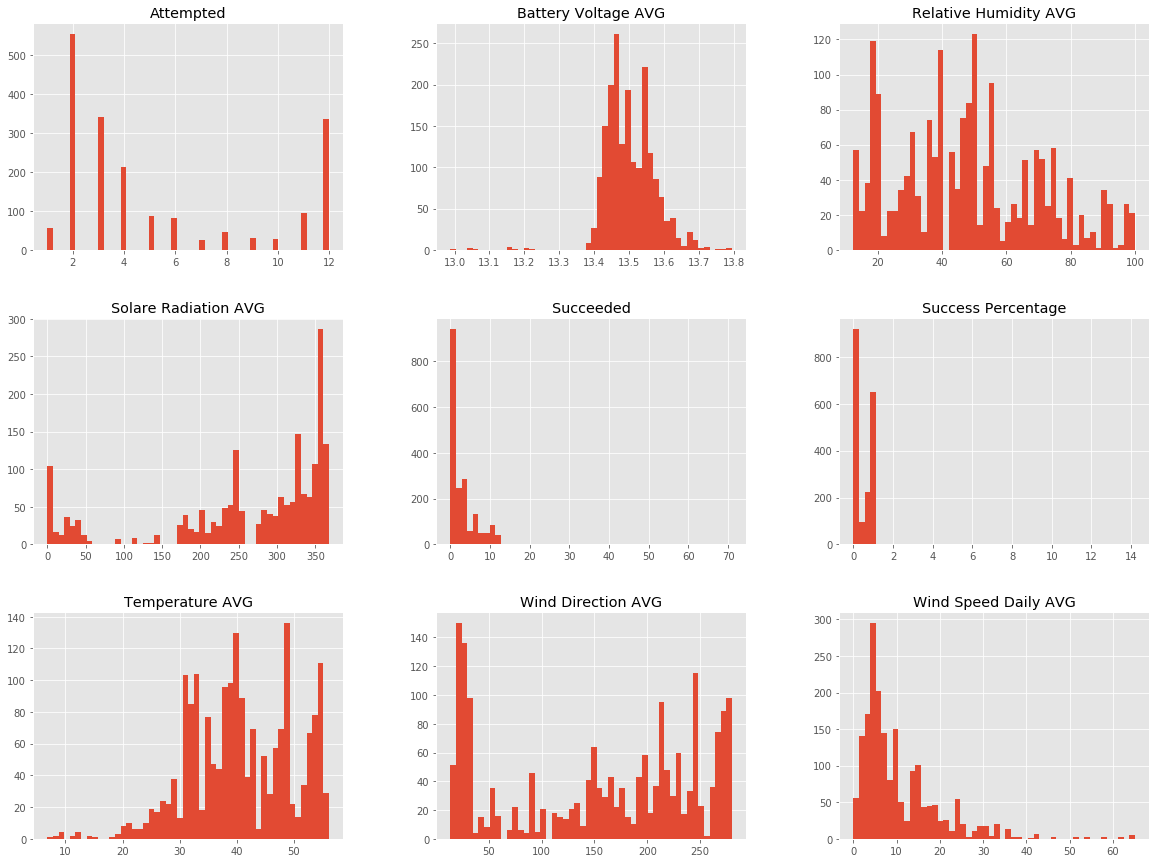

In [8]:
# Lets see histograms for all numeric features

data_countable = data._get_numeric_data()
data_countable.hist(bins = 50, figsize=(20,15))
plt.show()

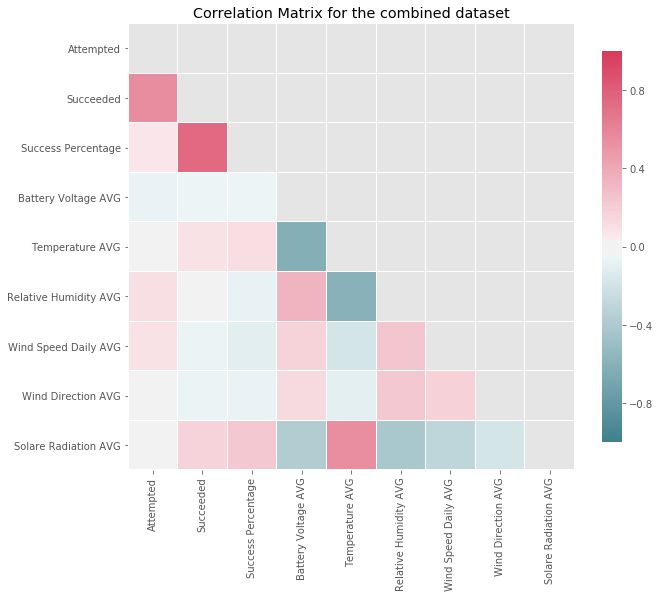

In [9]:
# Now plot a correlation matrix:

corr = data_countable.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 9))

cmap = sns.diverging_palette(210, 5, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix for the combined dataset')

plt.show()

What we can notice from the table above and the correlation matrix:

'Success Percentage' feature has an unexpected value of 14.2%, this is clearly an outlier (because 'Success Percentage'  ⊆[0,1] ). To preserve observations, I prefer to fix it the following way: where the values > 1, we'll make them = 1. Additionally, all succeeded attempts we'll make = number of attempts where they exceed.

There is a strong correlation between 'Succeeded' and 'Success Percentage' (logically), so we'll drop 'Succeeded' column.

'Battery Voltage AVG' indicated the battary voltage and seems to be backward correlated with 'Temperature AVG'. Nevertheless, we'll keep this column.
The cells below are all for the decisions we made previously:

In [0]:
# Let's first rename the target feature column (for convenience purpose only):

data.rename(columns={'Success Percentage' : 'SuccPerc'}, inplace=True)

In [0]:
# Bring 'Succeeded' to be equal 'Attempted' where 'Succeeded' > 'Attempted'

data.loc[data['Succeeded'] > data['Attempted'], 'Succeeded'] = data['Attempted']

# Now, locate the outliers and bring them to 1.

data.loc[data['SuccPerc'] > 1, 'SuccPerc'] = 1
data['SuccPerc'] = data['SuccPerc'].round(2)

For now, I'm going to keep all the columns and see how efficient the model could be.

Some additional EDA using Time Series:

In [0]:
# Set Date as index

ts = data.set_index('Date')

# Sort it

ts.sort_index(inplace=True)

In [13]:
print('The records about climbing successfulness from %s to %s' % (data.Date.min(), data.Date.max()))

The records about climbing successfulness from 1/23/2015 to 9/9/2015


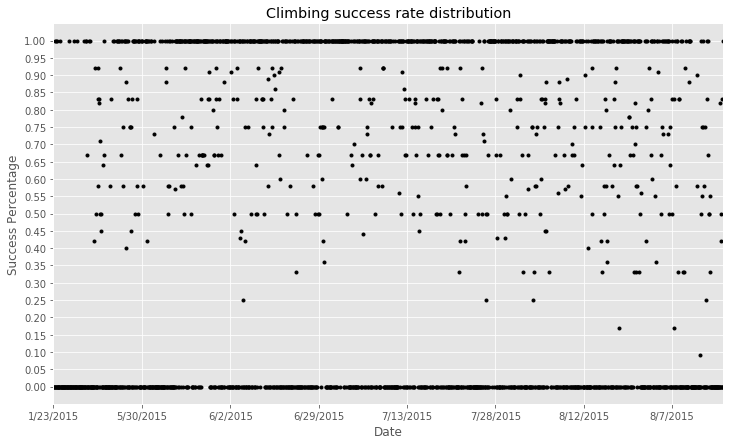

In [14]:
# Brief observation:

ts['SuccPerc'].plot(style='k.', figsize = (12,7))

plt.title('Climbing success rate distribution')
plt.ylabel('Success Percentage')
plt.yticks(np.linspace(0,1,21))
plt.show()

Here we see that a climbing season starts roughly in March and ends in October. So, let's consider only this interval

In [0]:
# Set the range

ts_mo = ts['2015-01-01':'2015-12-31']

In [19]:
ts_mo.shape

(0, 10)

AttributeError: ignored

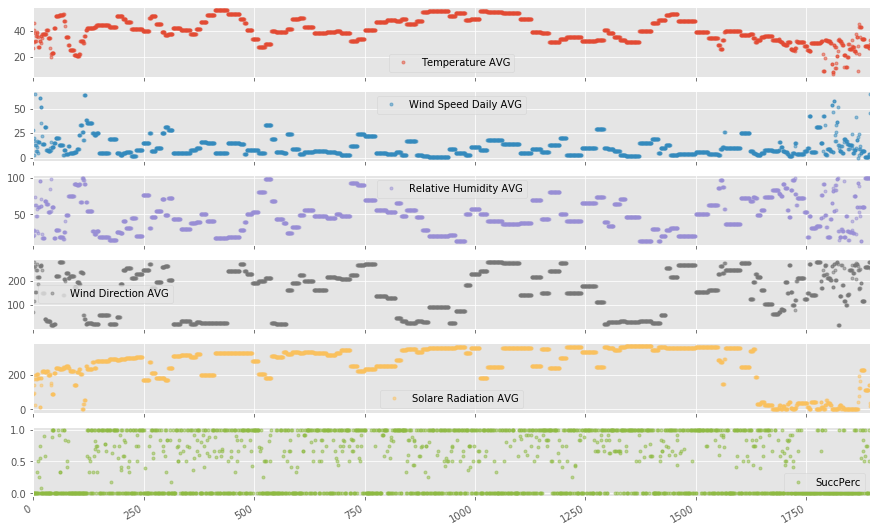

In [20]:
# Tiseries Multiplotting

cols_plot = ['Temperature AVG', 'Wind Speed Daily AVG', 'Relative Humidity AVG', 'Wind Direction AVG','Solare Radiation AVG', 'SuccPerc']


axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(15, 10), subplots=True)

for i, ax in enumerate(axes):
    ax.title.set_text('Time Series Data from {} to {}'.format(str(data.index.date.min()), str(data.index.date.max())))
    break


plt.show()

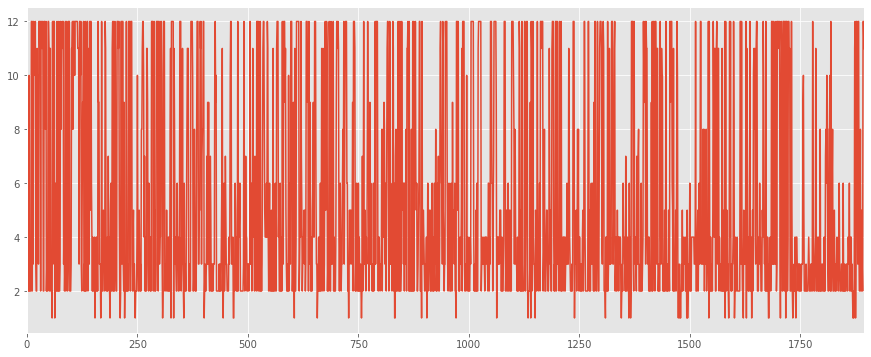

In [23]:
Attempt = data['Attempted']
Attempt.plot(figsize=(15, 6))
plt.show()

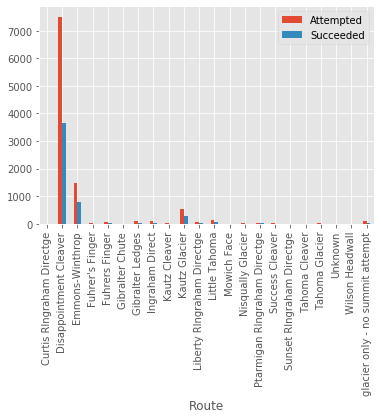

In [31]:
data=data.groupby(['Route'])["Attempted","Succeeded"].sum().reset_index()
data.plot(x='Route',y=["Attempted","Succeeded"],kind='bar')